# DM-31884: Milestone-DM-AP-12
## Test the AP pipeline by selecting visits from the diffim sprint with seeing between the best thirs of coadds and the middle third coadds. Convolve with the templates when using the best third set and with the science image when using the middle third and compare the results.

In [1]:

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import importlib
import pandas as pd

from astropy.coordinates import SkyCoord
import astropy.units as u
from types import SimpleNamespace
from astropy.visualization import (ZScaleInterval, SqrtStretch, ImageNormalize, LinearStretch)

import lsst.geom
import lsst.afw.display as afwDisplay
import lsst.afw.display as afw_display
afwDisplay.setDefaultBackend('matplotlib')
import lsst.daf.butler as dafButler
from lsst.ap.association import UnpackApdbFlags, TransformDiaSourceCatalogConfig
from lsst.pipe.base import Struct

import IPython
from IPython.display import IFrame

Overriding default configuration file with /opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/dustmaps_cachedata/g41a3ec361e+ce83317b7e/config/.dustmapsrc


In [2]:
sys.path.append('/project/kherner/DM-31884/ap_pipe-notebooks/')

In [3]:
import diaObjectAnalysis as doa
import apdbPlots as pla
import plotLightcurve as plc
import coaddAnalysis as coa

In [4]:
repo = '/repo/main'
butler = dafButler.Butler(repo)

In [5]:
default_best = SimpleNamespace(collection = 'u/kherner/DM-31844_best',
                               apdb = 'lsstdevapdb1',
                               schema = 'kherner_dm-31884_best_w46_20211111',
                              selname = 'bestThird')
middle_convolvesci = SimpleNamespace(collection = 'u/kherner/DM-31844_middle_convolveSci_20211122',
                                 apdb = 'lsstdevapdb1',
                                 schema = 'kherner_dm-31884_middle_convolvesci_w46_20211122',
                                selname = 'middleSeeing')
middle_convolvesci_old = SimpleNamespace(collection = 'u/kherner/DM-31844_middle_convolveSci',
                                 apdb = 'lsstdevapdb1',
                                 schema = 'kherner_dm-31884_middle_convolvesci_w46_20211111',
                                selname = 'middleSeeing')
preconvolve_best = SimpleNamespace(collection = 'u/kherner/DM-31844_best_Preconvolve_20211112',
                                apdb = 'lsstdevapdb1',
                               schema = 'kherner_dm_31884_best_preconvolve_w46_20211112',
                              selname = 'bestThird')
preconvolve_middle = SimpleNamespace(collection = 'u/kherner/DM-31844_middle_Preconvolve_20211124',
                                 apdb = 'lsstdevapdb1',
                                 schema = 'kherner_dm_31884_middle_preconvolve_w46_20211124',
                                     selname = 'middleSeeing')
preconvolve_middle_old = SimpleNamespace(collection = 'u/kherner/DM-31844_middle_Preconvolve',
                                 apdb = 'lsstdevapdb1',
                                 schema = 'kherner_dm_31884_middle_preconvolve_w46_20211111',
                                     selname = 'middleSeeing')

default_best = SimpleNamespace(collection = 'u/kherner/DM-31844_best_newTemplates_20211129',
                               apdb = 'lsstdevapdb1',
                               schema = 'kherner_dm_31884_best_w46_newtemplates_20211129',
                              selname = 'bestThird')
middle_convolvesci = SimpleNamespace(collection = 'u/kherner/DM-31844_middle_convolveSci_20211130',
                                 apdb = 'lsstdevapdb1',
                                 schema = 'kherner_dm_31884_middle_convolvesci_w46_20211128',
                                selname = 'middleSeeing')
middle_convolvesci_old = SimpleNamespace(collection = 'u/kherner/DM-31844_middle_convolveSci',
                                 apdb = 'lsstdevapdb1',
                                 schema = 'kherner_dm-31884_middle_convolvesci_w46_20211111',
                                selname = 'middleSeeing')
preconvolve_best = SimpleNamespace(collection = 'u/kherner/DM-31844_best_Preconvolve_20211130',
                                apdb = 'lsstdevapdb1',
                               schema = 'kherner_dm_31884_best_preconvolve_w46_20211130',
                              selname = 'bestThird')
preconvolve_middle = SimpleNamespace(collection = 'u/kherner/DM-31844_middle_Preconvolve_20211130',
                                 apdb = 'lsstdevapdb1',
                                 schema = 'kherner_dm_31884_middle_preconvolve_w46_20211130',
                                     selname = 'middleSeeing')
preconvolve_middle_old = SimpleNamespace(collection = 'u/kherner/DM-31844_middle_Preconvolve',
                                 apdb = 'lsstdevapdb1',
                                 schema = 'kherner_dm_31884_middle_preconvolve_w46_20211111',
                                     selname = 'middleSeeing')
#preconvolve_best22 = SimpleNamespace(collection = 'u/kherner/PREOPS-630_useScoreImageDetection_bestThird',
#                                apdb = 'lsstdevapdb1',
#                               schema = 'kherner_preops_630_useScoreImageDetection_bestthird',
#                              selname = 'bestThird')

The following represent the last runs, which were after changing the useScoreImage code path so it was no longer a no-op.

In [6]:
default_best22 = SimpleNamespace(collection = 'u/kherner/PREOPS-630_default_bestThird_20220201',
                                apdb = 'lsstdevapdb1',
                               schema = 'kherner_preops_630_default_bestthird_20220201',
                              selname = 'bestThird')
preconvolve_best22 = SimpleNamespace(collection = 'u/kherner/PREOPS-630_useScoreImageDetection_bestThird',
                                apdb = 'lsstdevapdb1',
                               schema = 'kherner_preops_630_usescoreimagedetection_bestthird_20220207',
                              selname = 'bestThird')
preconvolve_middle22 = SimpleNamespace(collection = 'u/kherner/PREOPS-630_useScoreImageDetection_midThird',
                                 apdb = 'lsstdevapdb1',
                                 schema = 'kherner_preops_630_useScoreImageDetection_midthird',
                                     selname = 'middleSeeing')


templates_best = 'u/kherner/PREOPS-630/templates_bestThirdSeeing_20210928'
templates_mid  = 'u/kherner/PREOPS-630/templates_midThirdSeeing_20210915'

In [7]:
sigma2fwhm = 2.*np.sqrt(2.*np.log(2.))

def getFWHM(collections, visit, band):
    dataId = {"band": band, "skymap": "hsc_rings_v1", "tract":9813,
              "visit":visit, "detector": 57}
    collname = 'calexp'
    #try:
    psf = butler.get(collname, instrument='HSC',
                          dataId=dataId, collections=collections).getPsf()
    fwhm = psf.computeShape().getDeterminantRadius()*sigma2fwhm
    #except:
    #    print("Unable to calculate psf for {}, visit {}".format(collname, visit))
    #    fwhm = 0
    return fwhm

Visit list for best third seeing coadds: 

In [8]:
bestg = [11704, 11702, 11694, 11698, 11692, 11696]
bestr = [23694, 1208, 1218, 23692, 1220]

middle seeing coadds:

In [9]:
midg =  [11700, 11706, 11690, 11708, 29340, 11710]
midr =  [23704, 1216, 1204, 1214, 23718]

Science images for g and r band. Note that the science images are chosen to have seeing worse than the best third templates, but better than the middle third.

In [10]:
scienceg = [11690, 11692, 11694, 11696, 11698, 11700, 11702, 11704, 11706, 11708, 11710, 11712, 29324, 29326, 29336, 29340, 29350]

sciencer = [1202, 1204, 1206, 1208, 1210, 1212, 1214, 1216, 1218, 1220, 23692, 23694, 23704, 23706, 23716, 23718]

for each visit above, only these detectors (ccds)
49, 50, 57, 58, 65, 66

Then we need to select from the last two lists, only those exposures with seeing between the two sets of coadds

In [11]:
for visit in bestg:
    mypsf = getFWHM(templates_best, visit, 'g')
    print("{} {}".format(visit,mypsf))

/tmp/ipykernel_693/424442732.py:10: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  fwhm = psf.computeShape().getDeterminantRadius()*sigma2fwhm


11704 4.196526734001885
11702 4.313148629010395
11694 4.376509731164507
11698 4.41213607910718
11692 4.464554360355094
11696 4.470076147498122


In [12]:
for visit in bestr:
    mypsf = getFWHM(templates_best, visit, 'r')
    print("{} {}".format(visit,mypsf))

/tmp/ipykernel_693/424442732.py:10: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  fwhm = psf.computeShape().getDeterminantRadius()*sigma2fwhm


23694 2.651384078097193
1208 2.8461583885685124
1218 2.9227737938150202
23692 2.8830870392238115
1220 2.995437131951539


In [13]:
for visit in scienceg:
    if visit not in bestg and visit not in midg:
        mypsf = getFWHM(default_best.collection, visit, 'g')
        print("{} {}".format(visit,mypsf))

/tmp/ipykernel_693/424442732.py:10: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  fwhm = psf.computeShape().getDeterminantRadius()*sigma2fwhm


11712 5.474440560716145
29324 5.417193715779091
29326 5.680185062087482
29336 5.521535384411122
29350 7.063558819111072


In [14]:
for visit in sciencer:
    if visit not in bestr and visit not in midr:
        mypsf = getFWHM(default_best.collection, visit, 'r')
        print("{} {}".format(visit,mypsf))

/tmp/ipykernel_693/424442732.py:10: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  fwhm = psf.computeShape().getDeterminantRadius()*sigma2fwhm


1202 4.103281350445766
1206 4.73490227076808
1210 4.667862592937892
1212 5.040135608324652
23706 3.484042499813854
23716 3.70171688532309


In [15]:
for visit in midg:
    mypsf = getFWHM(templates_mid, visit, 'g')
    print("{} {}".format(visit,mypsf))

/tmp/ipykernel_693/424442732.py:10: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  fwhm = psf.computeShape().getDeterminantRadius()*sigma2fwhm


11700 4.526856468497831
11706 4.573588440616961
11690 4.670173700045059
11708 4.7999038623148795
29340 4.974679056664786
11710 5.25024838143603


In [16]:
for visit in midr:
    mypsf = getFWHM(templates_mid, visit, 'r')
    print("{} {}".format(visit,mypsf))

/tmp/ipykernel_693/424442732.py:10: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  fwhm = psf.computeShape().getDeterminantRadius()*sigma2fwhm


23704 2.990418642626827
1216 3.0505942887918476
1204 3.290396097777896
1214 3.3232701951872463
23718 3.310859699218506


In [17]:

badFlagList = ['base_PixelFlags_flag_bad',
               'base_PixelFlags_flag_suspect',
               'base_PixelFlags_flag_saturatedCenter',
               'base_PixelFlags_flag_interpolated',
               'base_PixelFlags_flag_interpolatedCenter',
               'base_PixelFlags_flag_edge',
              ]

apdbs_nonempty = [ default_best22, preconvolve_best22]
print(f'N DiaSources and N "good" DiaSources in each collection')
print(f'-------------------------------------------------------')
for run in apdbs_nonempty:
    collection = run.collection
    apdb = run.apdb
    schema = run.schema
    objTable, srcTable, goodObj, goodSrc = pla.loadTables(repo,
                                                          dbType='postgres',
                                                          dbName=apdb,
                                                          gen='gen3',
                                                          schema=schema,
                                                          instrument='HSC',
                                                          badFlagList=badFlagList)
    print(f'{len(srcTable):7d}\t{len(goodSrc):7d}\t\t{collection.split("/")[-1]}')

N DiaSources and N "good" DiaSources in each collection
-------------------------------------------------------


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-3.0.0/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-3.0.0/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


 206058	  92014		PREOPS-630_default_bestThird_20220201


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-3.0.0/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-3.0.0/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


  65344	  29548		PREOPS-630_useScoreImageDetection_bestThird


Let's look at some calexps and diffimg outputs. Pick a single visit and detector semi-randomly.

In [18]:
collection_list = [default_best22, preconvolve_best22]
oneVisit = 29350 #, 11696, 1218, 1220, 11700, 11706, 23704, 1216)
oneDetector = 49 #, 50, 57, 58, 65, 66)

diffim variance median
----------------------
236.381165	PREOPS-630_default_bestThird_20220201
1.466783	PREOPS-630_useScoreImageDetection_bestThird


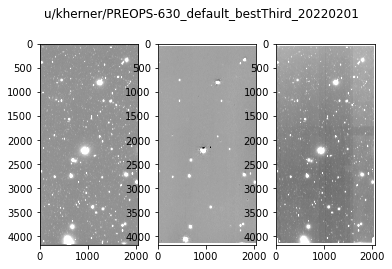

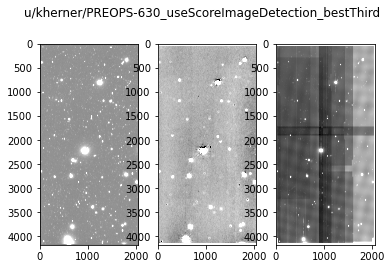

In [19]:
print(f'diffim variance median')
print(f'----------------------')
for collections in collection_list:
#for collections in [default_best.collection, preconvolve_best.collection]:
    calexp = butler.get('calexp', instrument='HSC',
                        visit=oneVisit, detector=oneDetector, collections=collections.collection)
    try:
        diffim = butler.get(collections.selname+'Diff_differenceExp', instrument='HSC',
                        visit=oneVisit, detector=oneDetector, collections=collections.collection)
    except:
        diffim = butler.get(collections.selname+'Diff_scoreExp', instrument='HSC',
                        visit=oneVisit, detector=oneDetector, collections=collections.collection)
    calexpNorm = ImageNormalize(calexp.image.array, interval=ZScaleInterval(), stretch=SqrtStretch())
    diffimNorm = ImageNormalize(diffim.image.array, interval=ZScaleInterval(), stretch=SqrtStretch())
    diffimVarNorm = ImageNormalize(diffim.variance.array, interval=ZScaleInterval(), stretch=SqrtStretch())

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.suptitle(collections.collection)
    ax1.imshow(calexp.image.array, cmap='gray', norm=calexpNorm)
    ax2.imshow(diffim.image.array, cmap='gray', norm=diffimNorm)
    ax3.imshow(diffim.variance.array, cmap='gray', norm=diffimVarNorm)
    
    print(f'{np.median(diffim.variance.array):8f}\t{(collections.collection).split("/")[-1]}')

Same thing but different visit and ccd

645.325439	PREOPS-630_default_bestThird_20220201
33.990028	PREOPS-630_useScoreImageDetection_bestThird


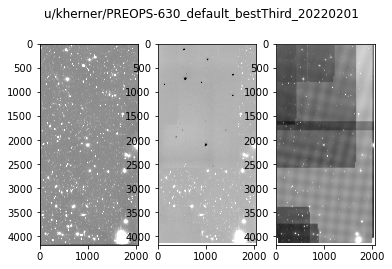

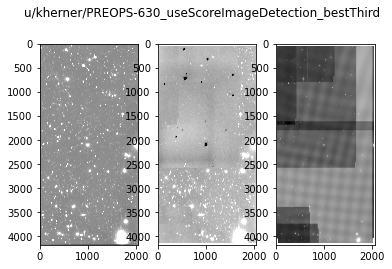

In [20]:
oneVisit = 1220 #, 11696, 1218, 1220, 11700, 11706, 23704, 1216)
oneDetector = 49

for collections in collection_list:
    calexp = butler.get('calexp', instrument='HSC',
                        visit=oneVisit, detector=oneDetector, collections=collections.collection)
    try:
        diffim = butler.get(collections.selname+'Diff_differenceExp', instrument='HSC',
                        visit=oneVisit, detector=oneDetector, collections=collections.collection)
    except:
        diffim = butler.get(collections.selname+'Diff_scoreExp', instrument='HSC',
                        visit=oneVisit, detector=oneDetector, collections=collections.collection)
    calexpNorm = ImageNormalize(calexp.image.array, interval=ZScaleInterval(), stretch=SqrtStretch())
    diffimNorm = ImageNormalize(diffim.image.array, interval=ZScaleInterval(), stretch=SqrtStretch())
    diffimVarNorm = ImageNormalize(diffim.variance.array, interval=ZScaleInterval(), stretch=SqrtStretch())

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.suptitle(collections.collection)
    ax1.imshow(calexp.image.array, cmap='gray', norm=calexpNorm)
    ax2.imshow(diffim.image.array, cmap='gray', norm=diffimNorm)
    ax3.imshow(diffim.variance.array, cmap='gray', norm=diffimVarNorm)
    
    print(f'{np.median(diffim.variance.array):8f}\t{(collections.collection).split("/")[-1]}')

In [21]:
def makeplots(run):
    collection = run.collection
    apdb = run.apdb
    schema=run.schema
    print(collection, apdb)
    dbPath = apdb
    objTable, srcTable, goodObj, goodSrc = pla.loadTables(repo,
                                                          dbType='postgres',
                                                          dbName=dbPath,
                                                          schema=schema,
                                                          gen='gen3',
                                                          instrument='HSC')
    srcTable = pla.addVisitCcdToSrcTable(srcTable, instrument='HSC', gen='gen3', butler=butler)
    flagTable, srcTableFlags, flagFilter, goodSrc, goodObj = pla.makeSrcTableFlags(srcTable, objTable,
                                                                                   badFlagList=badFlagList,
                                                                                   gen='gen3', instrument='HSC',
                                                                                   repo=repo)
    # Good DIA Sources
    fig = plt.figure(figsize=(4,4))
    xlim = (150.45, 149.8)
    ylim = (2.1, 2.5)
    ax = fig.add_subplot(111)
    plt.setp(ax, xlim=xlim, ylim=ylim)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.scatter(goodSrc['ra'], goodSrc['decl'], c='C0', s=0.1, marker='o', alpha=0.4)
    ax.set_xlabel('RA (deg)')
    ax.set_ylabel('Dec (deg)')
    ax.set_title(f'DIA Sources ({str(collection).split("/")[-1]})')
    
    # Good DIA Sources by visit
    bandList = ['g', 'r']
    colorList = ['C2', 'C1']
    for band, color in zip(bandList, colorList):
        pla.plotDiaSourcesOnSkyGrid(repo, goodSrc.loc[goodSrc['filterName'] == band],
                                    title=band+' band', color=color, size=5)
    
    # How many DIA Sources comprise each DIA Object
    hist = doa.plotDiaObjectHistogram(objTable, goodObj)
    
    # Flag bar chart
    pla.plotFlagHist(srcTable, badFlagList=badFlagList)
    
    # Flux distributions
    pla.plotFluxHistSrc(goodSrc.loc[goodSrc['filterName'] == 'g'], fluxType='psFlux',
                        title='DIA Sources, HSC-G, Diffim PSF Flux', color1='C2', binmin=-1e3, binmax=1e3)
    pla.plotFluxHistSrc(goodSrc.loc[goodSrc['filterName'] == 'r'], fluxType='psFlux',
                        title='DIA Sources, HSC-R, Diffim PSF Flux', color1='C1', binmin=-1e3, binmax=1e3)
    pla.plotFluxHistSrc(goodSrc.loc[goodSrc['filterName'] == 'g'], fluxType='totFlux',
                        title='DIA Sources, HSC-G, Calexp PSF Flux', color1='C2', binmin=-1e3, binmax=2e3)
    pla.plotFluxHistSrc(goodSrc.loc[goodSrc['filterName'] == 'r'], fluxType='totFlux',
                        title='DIA Sources, HSC-R2, Calexp PSF Flux', color1='C1', binmin=-1e3, binmax=2e3)
    
    # Flux histograms
    pla.source_magnitude_histogram(repo, goodSrc, 'g', 'HSC', collection)
    pla.source_magnitude_histogram(repo, goodSrc, 'r', 'HSC', collection)
    
    # A few cutouts
    for index, source in goodSrc[:4].iterrows():
        dataId = {'detector': int(goodSrc['ccd'][index]), 'visit': int(goodSrc['visit'][index]), 'instrument': 'HSC'}
        center = lsst.geom.SpherePoint(goodSrc['ra'][index], goodSrc['decl'][index], lsst.geom.degrees)
        try:
            scienceCutout, differenceCutout, templateCutout = plc.retrieveCutouts(butler, dataId, collection, center, diffName=run.selname)
            plc.plotCutout(scienceCutout, differenceCutout, templateCutout)
        except:
            print('Error plotting cutouts for ' + str(dataId))

In [22]:
def allTables(run):

    collection = run.collection
    apdb = run.apdb
    schema=run.schema
    dbPath = apdb

    objTable, srcTable, goodObj, goodSrc = pla.loadTables(repo,
                                                          dbType='postgres',
                                                          dbName=dbPath,
                                                          schema=schema,
                                                          gen='gen3',
                                                          instrument='HSC')
    srcTable = pla.addVisitCcdToSrcTable(srcTable, instrument='HSC', gen='gen3', butler=butler)
    
    flagTable, srcTableFlags, flagFilter, goodSrc, goodObj = pla.makeSrcTableFlags(srcTable, objTable,
                                                                                   badFlagList=badFlagList,
                                                                                   gen='gen3', instrument='HSC',
                                                                                   repo=repo)
    
    return flagTable, srcTableFlags, flagFilter, goodSrc, goodObj, objTable, srcTable

### Plot good sources. The machinery is here for making a cut on flux, but it isn't used in this case.

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-3.0.0/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-3.0.0/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-3.0.0/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy


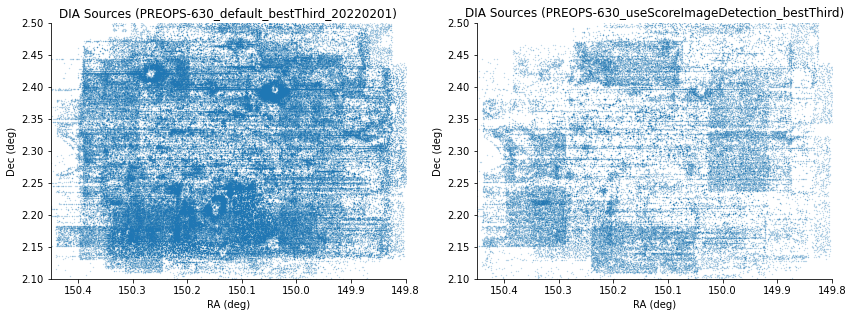

In [23]:
 # Good DIA Sources
fig = plt.figure(figsize=[14.0, 16.0])
gspec = fig.add_gridspec(3, 2)
xlim = (150.45, 149.8)
ylim = (2.1, 2.5)
iplt = 0
for collection in collection_list:
    flagTable, srcTableFlags, flagFilter, goodSrc, goodObj, objTable, srcTable = allTables(collection)
    fluxcut = 1500.0 # value of 1500 determined below.
    BS = srcTable.loc[abs(srcTable['apFlux'])>=fluxcut]
    goodBS = goodSrc.loc[abs(goodSrc['apFlux'])>=fluxcut]
    ax = fig.add_subplot(gspec[int(iplt/2),iplt%2])
    plt.setp(ax, xlim=xlim, ylim=ylim)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.scatter(srcTable['ra'], srcTable['decl'], c='C0', s=0.1, marker='o', alpha=0.4)
    ax.set_xlabel('RA (deg)')
    ax.set_ylabel('Dec (deg)')
    ax.set_title(f'DIA Sources ({str(collection.collection).split("/")[-1]})')
    iplt += 1

### Make a fixed flux cut (as opposed to a sigma-based cut) and compare source positions in different cases. Ideally we would have perfect overlap in the plot on the bottom between different cases.

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-3.0.0/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-3.0.0/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-3.0.0/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy


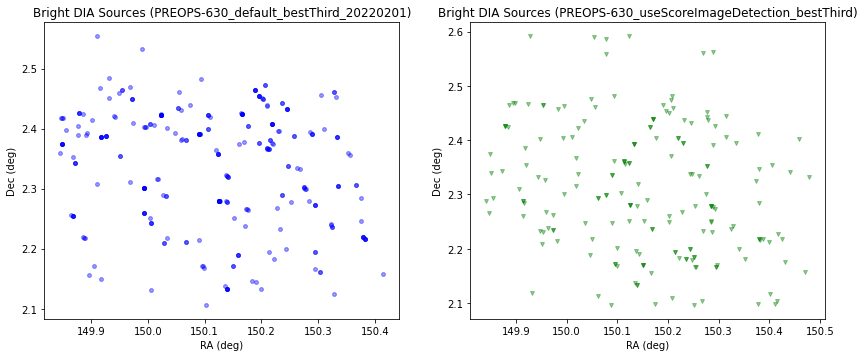

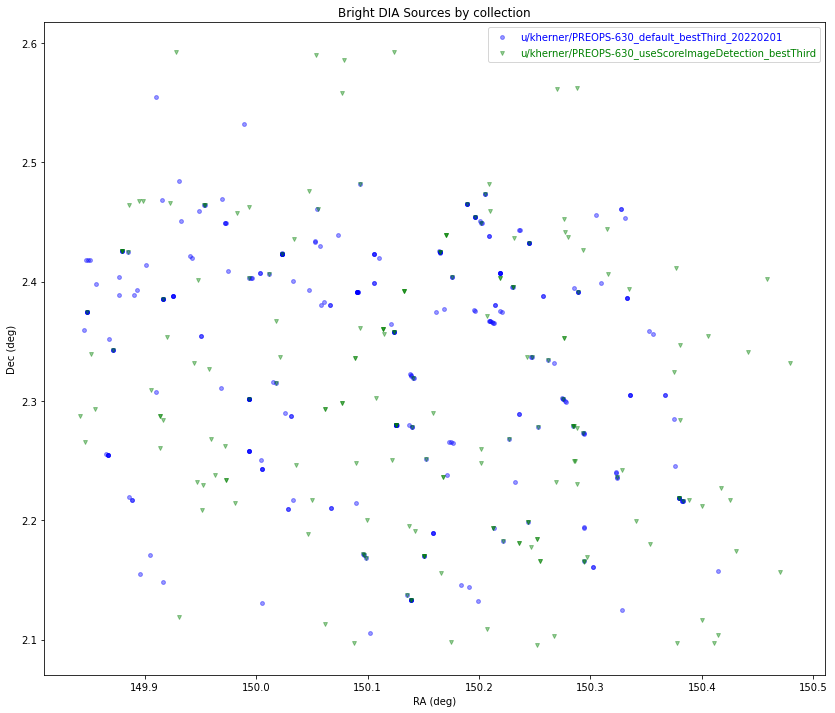

In [24]:
histfig =  plt.figure(figsize=[14.0, 12.0])
overlayfig =  plt.figure(figsize=[14.0, 12.0])
histgspec = histfig.add_gridspec(2, 2)
#collection_list = [default_best, middle_convolvesci, preconvolve_best, preconvolve_middle]
collection_list = [default_best22, preconvolve_best22]
iplt = 0
olax = overlayfig.add_subplot()
olax.set_xlabel('RA (deg)')
olax.set_ylabel('Dec (deg)')
olax.set_title(f'Bright DIA Sources by collection')
#color = [ 'b', 'g', 'r', 'k', 'y', 'c']
color = [ 'b', 'g', 'r', 'k']
#mrkr = [ 'o', 'v', 's', '*', '^', 'p' ]
mrkr = [ 'o', 'v', 's', '*']
for collection in collection_list: 
    flagTable, srcTableFlags, flagFilter, goodSrc, goodObj, objTable, srcTable = allTables(collection)
    fluxcut = 1500.0
    BS = srcTable.loc[abs(srcTable['apFlux'])>=fluxcut]
    goodBS = goodSrc.loc[abs(goodSrc['apFlux'])>=fluxcut]
    histax = histfig.add_subplot(histgspec[int(iplt/2),iplt%2])
    histax.scatter(goodBS['ra'], goodBS['decl'], c=color[iplt], s=15.0, marker=mrkr[iplt], alpha=0.4)
    histax.set_xlabel('RA (deg)')
    histax.set_ylabel('Dec (deg)')
    histax.set_title(f'Bright DIA Sources ({str(collection.collection).split("/")[-1]})')
    olax.scatter(goodBS['ra'], goodBS['decl'], color=color[iplt], s=15.0, marker=mrkr[iplt], alpha=0.4) 
    # How many DIA Sources comprise each DIA Object
    
    iplt += 1
    # Good DIA Sources by visit
    # bandList = ['g', 'r']
    # colorList = ['C2', 'C1']
    # for band, color in zip(bandList, colorList):
    #    pla.plotDiaSourcesOnSkyGrid(repo, goodSrc.loc[goodSrc['filterName'] == band],
    #                                title=band+' band', color=color, size=5)
mylegend = plt.legend(olax, loc='best', labelcolor=color, labels = [ coll.collection for coll in collection_list])

u/kherner/PREOPS-630_default_bestThird_20220201 lsstdevapdb1


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-3.0.0/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-3.0.0/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


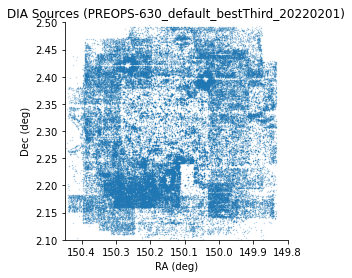

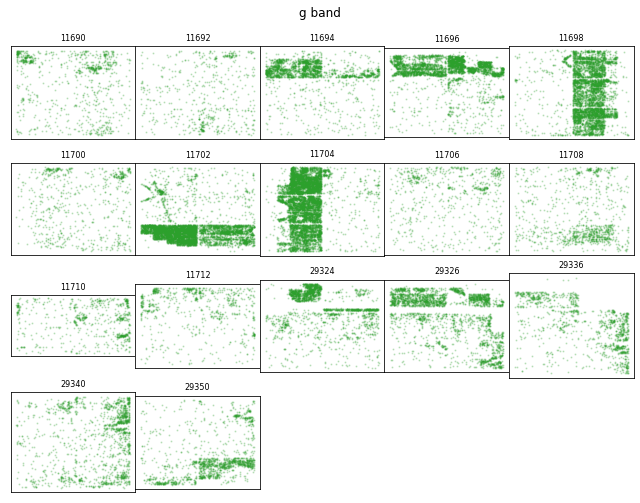

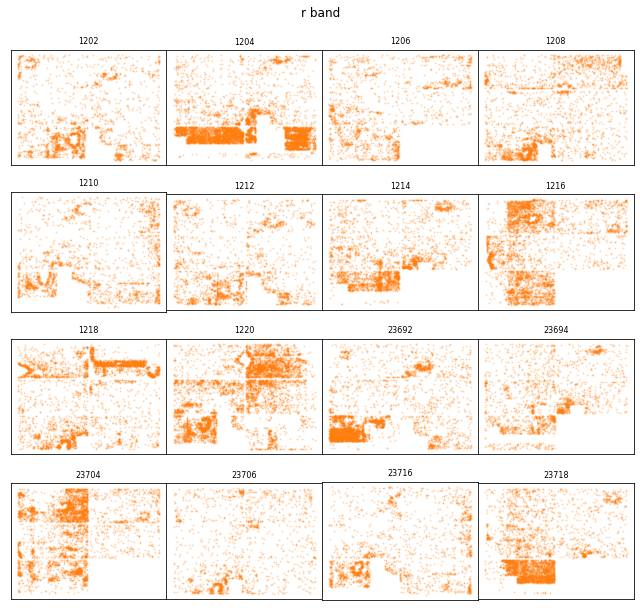

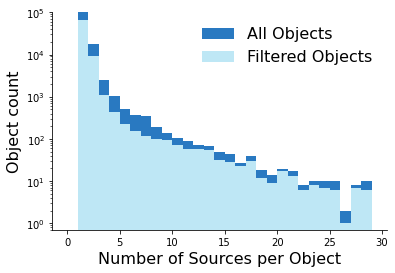

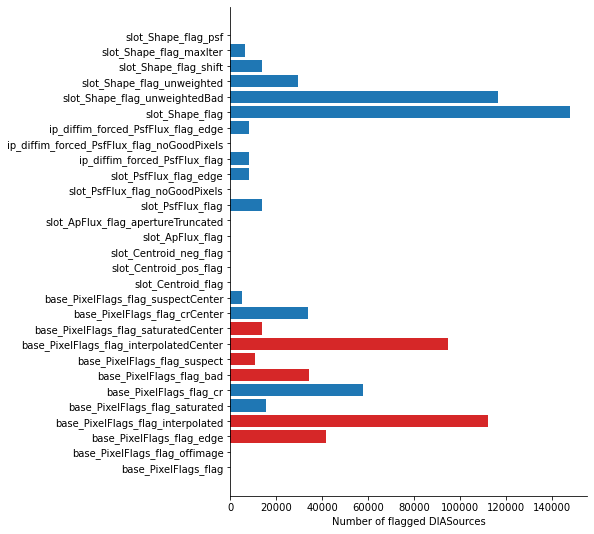

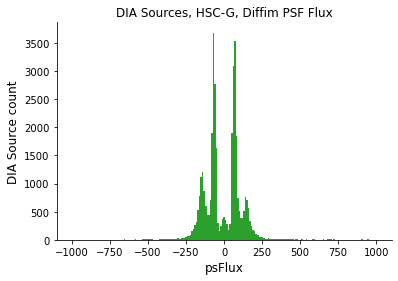

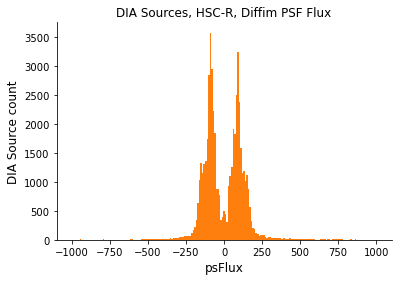

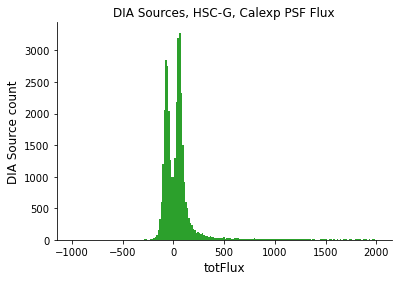

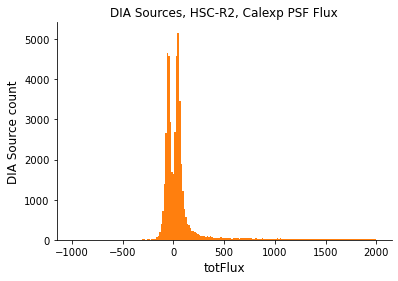

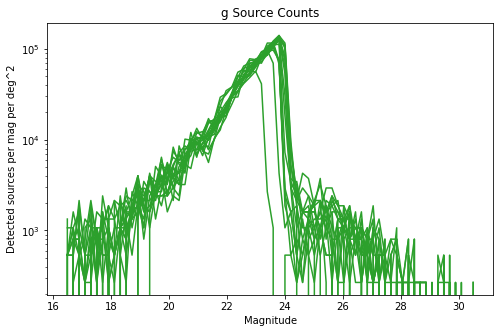

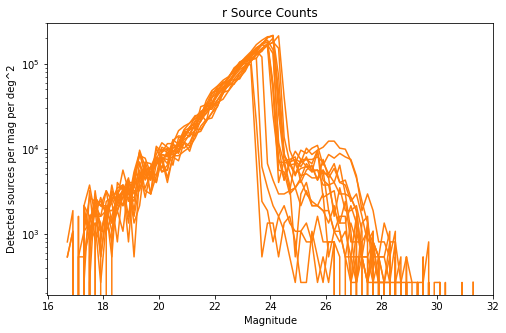

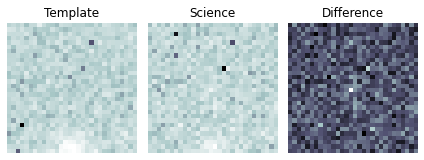

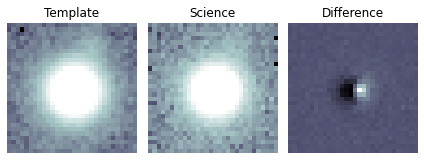

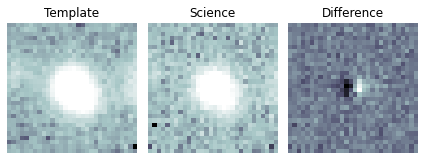

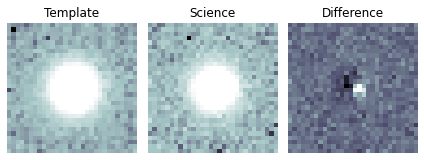

In [25]:
makeplots(default_best22)

u/kherner/PREOPS-630_useScoreImageDetection_bestThird lsstdevapdb1


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-3.0.0/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-3.0.0/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


Error plotting cutouts for {'detector': 65, 'visit': 29324, 'instrument': 'HSC'}
Error plotting cutouts for {'detector': 65, 'visit': 29324, 'instrument': 'HSC'}
Error plotting cutouts for {'detector': 65, 'visit': 29324, 'instrument': 'HSC'}
Error plotting cutouts for {'detector': 65, 'visit': 29324, 'instrument': 'HSC'}


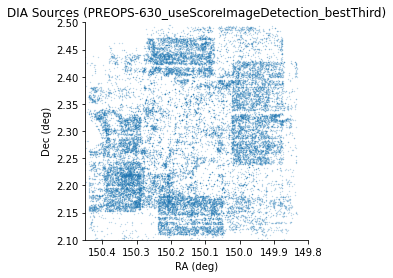

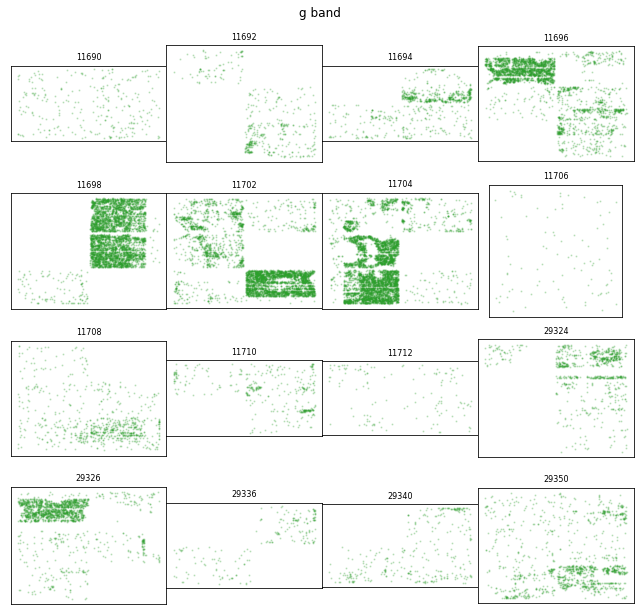

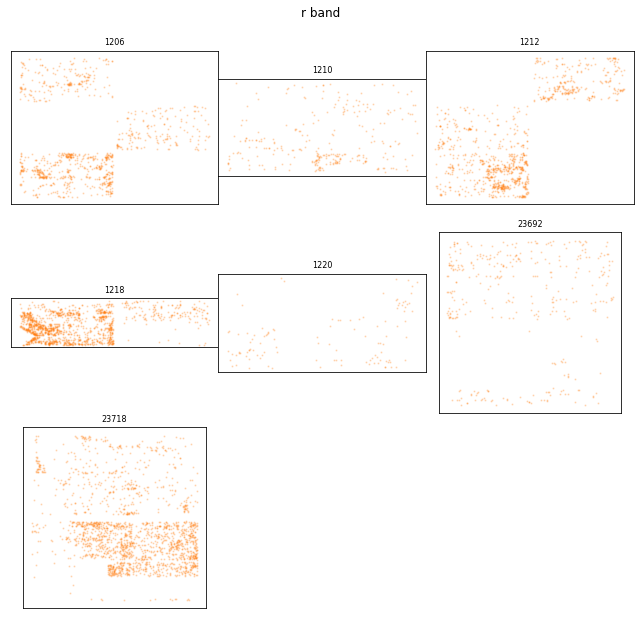

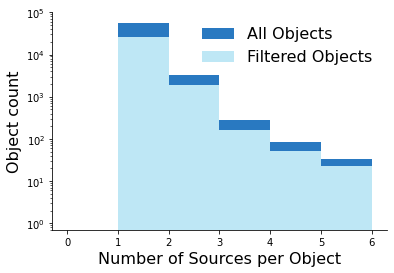

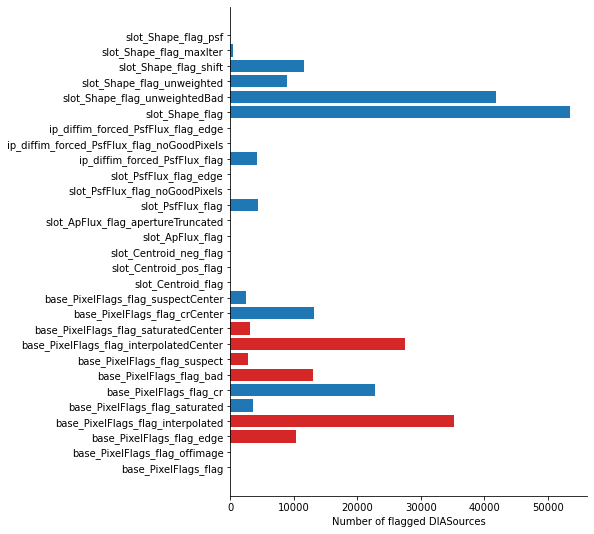

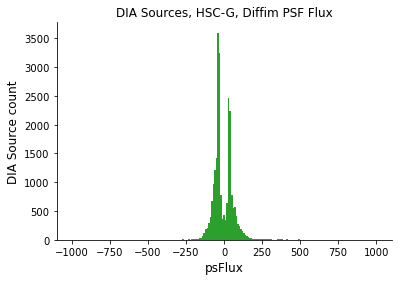

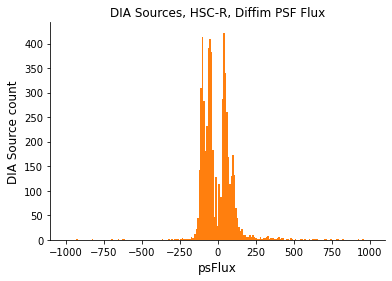

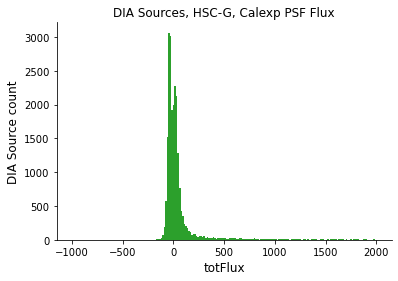

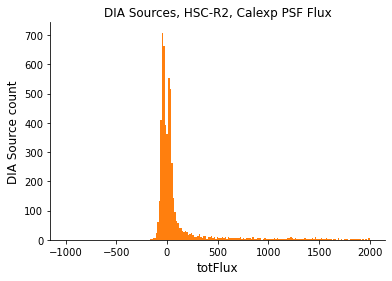

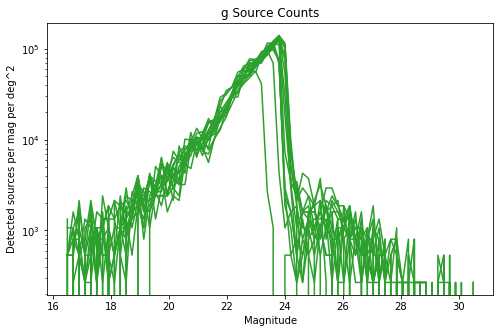

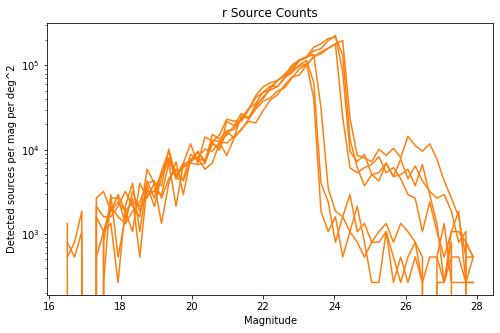

In [26]:
makeplots(preconvolve_best22)

In [ ]:
makeplots(middle_convolvesci) # old, from before useScoreImageDetection changes

In [ ]:
makeplots(preconvolve_middle) # old, from before useScoreImageDetection changes

### make source plots for a absolute flux cutoff that corresponds roughly to 20 sigma in the convolve sicnece image case and apply to each of the cases.

In [27]:
flagTable, srcTableFlags, flagFilter, goodSrc, goodObj,
objTable, srcTable = allTables(default_best22)

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-3.0.0/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-3.0.0/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


(0.0, 40.0)

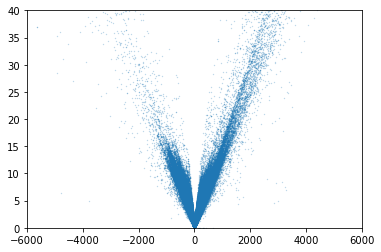

In [28]:
xlim = (-6000, 6000)
ylim = (0, 40)
plt.scatter(srcTable['apFlux'],
            abs(srcTable['apFlux']/srcTable['apFluxErr']),
            c='C0', s=0.1, marker='o', alpha=0.4)
plt.xlim(xlim)
plt.ylim(ylim)

Looks like abs(apFlux) > 1500 gets us to ~ 20 sigma 

In [29]:
fluxcut = 1500.0
BS = srcTable.loc[abs(srcTable['apFlux'])>=fluxcut]
goodBS = goodSrc.loc[abs(goodSrc['apFlux'])>=fluxcut]

### Plot cutouts of the first 100 good sources. Could be any collection but default_best22 is here as a placeholder.

In [31]:
flagTable, srcTableFlags, flagFilter, goodSrc, goodObj, \
objTable, srcTable = allTables(default_best22)
collection = default_best22.collection
run = default_best22

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-3.0.0/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-3.0.0/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


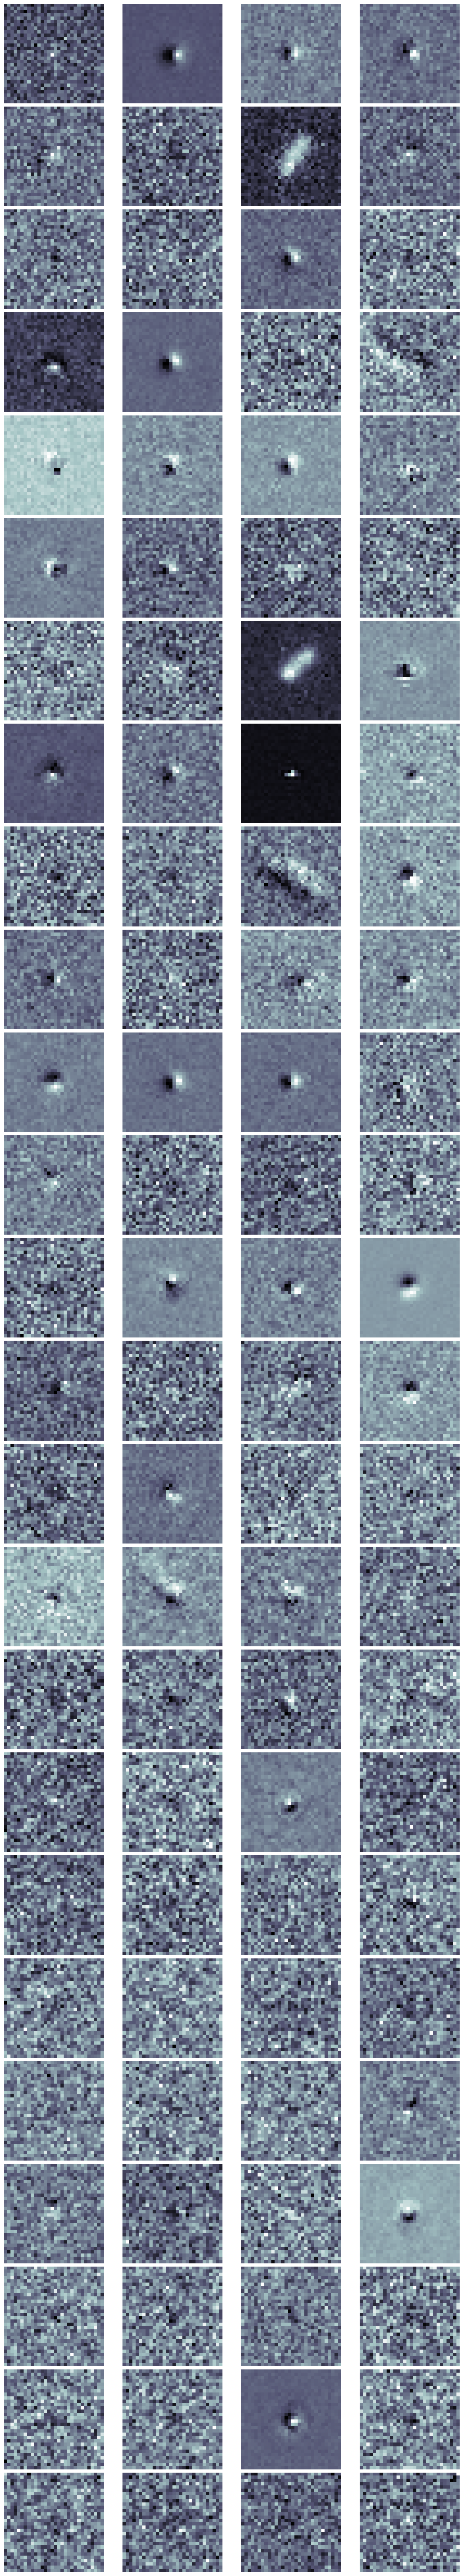

In [32]:
iplt = 0
nrow = 25
ncols= 4
cutoutplt =  plt.figure(figsize=[12.0, 65.0], constrained_layout=True)
cospec = cutoutplt.add_gridspec(nrow, ncols)
for index, source in goodSrc[:100].iterrows():
        dataId = {'detector': int(goodSrc['ccd'][index]),
                  'visit': int(goodSrc['visit'][index]),
                  'instrument': 'HSC'}
        center = lsst.geom.SpherePoint(goodSrc['ra'][index],
                                       goodSrc['decl'][index],
                                       lsst.geom.degrees)
        scienceCutout, differenceCutout, templateCutout = plc.retrieveCutouts(butler, 
                                                                              dataId, 
                                                                              collection,
                                                                              center,
                                                                              diffName=run.selname)
        myax = cutoutplt.add_subplot(cospec[int(iplt/ncols), iplt%ncols])
        interval = ZScaleInterval()
        data = differenceCutout.image.array
        norm = ImageNormalize(data, stretch=LinearStretch())
        myax.imshow(data, cmap=plt.cm.bone,
                    interpolation="none", norm=norm)
        myax.axis('off')
        iplt += 1

## Summary

We see that with and without preconvolution on the best third seeing templates do not produce identical results, even when considering only bright sources. 
As of March 2022 we have put the studies on hold and will repeat them once the image differencing refactoring is complete.
When we resume the studies, we will compare between our usual four cases:

- Default ap_pipe config options using the best third seeing templates
- Preconvolution using the best third seeing templates
- Preconvolution with the middle third seeing templates
- Convolving the science image instead of template using the middle third seeing templates (more accurately, using the score image detection)
